# Classification:bearing

## 1. Predicting the final destination of bikes

Independent variables:
* start latitude
* start longitude
* datetime
* weather data

Target variables:
* first step: cardinal direction
* second step: actual station

Visualization:
* Some sort of interactive map where you can click on a start station, and a heath circle shows up around it indicating the bike flow intensity.

In [1]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import GridSearchCV

%matplotlib inline

/home/aleksandra/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# connect to the remote database
cnx = create_engine('####')

For now, without winddirection, because I do not know how to deal with the variable direction yet.

In [3]:
data = pd.read_sql_query('''SELECT cardinal, startstationlatitude, startstationlongitude, user_dummy, visibility, 
drybulbtempc, wetbulbtempc, windspeed, precip 
FROM geodata INNER JOIN bikeshare ON bikeshare.rideid = geodata.rideid 
INNER JOIN weatherdata ON bikeshare.start_hour = weatherdata.date''', cnx)

In [8]:
data.head()

,cardinal,startstationlatitude,startstationlongitude,user_dummy,visibility,drybulbtempc,wetbulbtempc,windspeed,precip
0,E,40.716887,-73.963198,1,10.0,4.4,1.6,5.0,0.0
1,N,40.685396,-73.974315,1,10.0,4.4,1.4,9.0,0.0
2,W,40.760875,-74.002777,1,10.0,4.4,1.4,14.0,0.0
3,E,40.680983,-73.950048,1,10.0,4.4,1.4,14.0,0.0
4,NE,40.711731,-73.991930,1,10.0,4.4,1.4,14.0,0.0


In [9]:
len(data)

9726711

We lost about a million datapoints, because no weather information is available for those date-hours.

In [10]:
len(data.dropna())

9726711

No null values anywhere, so we can start modeling.

In [4]:
y = data.cardinal
X = data.drop('cardinal', 1)

In [6]:
print(y.shape)
print(X.shape)

(9726711,)
(9726711, 8)


Run all the models to get an idea:

In [13]:
def statistics_CV(model, X, y):
    accuracy = cross_val_score(model, X, y, scoring = 'accuracy').mean()
    precision = cross_val_score(model, X, y, scoring = 'precision').mean()
    recall = cross_val_score(model, X, y, scoring = 'recall').mean()
    f1 = cross_val_score(model, X, y, scoring = 'f1').mean()
    print(model)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('Recall: ', recall)
    print('F1 score: ', f1)
    print('\n')

In [14]:
from collections import defaultdict

def statistics_CV2(model, X, y):
    '''takes list of model, instantiation of the model and returns dict with accuracy score, precision, recall,
    f1, fpr, tpr, auc'''
    cv = StratifiedKFold(n_splits=6)
    lgr = model[1]
    scores = defaultdict(list)
    for train, test in cv.split(X, y):
        lgr.fit(X_train, y_train)
        y_pred = lgr.predict(X_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
        scores[model[0]].append(metrics.accuracy_score(y_test, y_pred))
        scores[model[0]].append(metrics.precision_score(y_test, y_pred))
        scores[model[0]].append(metrics.recall_score(y_test, y_pred))
        scores[model[0]].append(metrics.f1_score(y_test, y_pred))
        scores[model[0]].append(fpr)
        scores[model[0]].append(tpr)
        scores[model[0]].append(metrics.auc(fpr, tpr))
    return scores

In [ ]:
#for model in [KNeighborsClassifier(n_jobs = -1), LogisticRegression(n_jobs = -1), 
#              RandomForestClassifier(n_jobs = -1)]:
#    statistics_CV(model, X, y)
# gaussian, svc, decisiontree do not have n_jobs

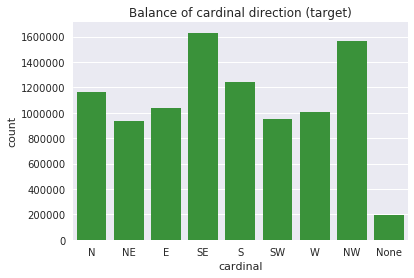

In [7]:
order = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'None']
sns.countplot(y, order=order, color='tab:green')
plt.title('Balance of cardinal direction (target)')

In [ ]:
statistics = []
#for model in [('KNN', KNeighborsClassifier(n_jobs = -1)), ('Logistic Regression', LogisticRegression(n_jobs = -1)), 
#              ('Random Forest', RandomForestClassifier(n_jobs = -1))]:
#    statistics.append(statistics_CV2(model, X, y))

In [5]:
def statistics_CV_pr(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
    mod = model
    mod.fit(X_train, y_train)
    y_pred = mod.predict(X_test)
    print(model)
    print(metrics.classification_report(y_test, y_pred))

In [6]:
statistics_CV_pr(LogisticRegression(n_jobs=6), X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=6,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
             precision    recall  f1-score   support

          E       0.00      0.00      0.00    260469
          N       0.25      0.00      0.00    291765
         NE       0.00      0.00      0.00    232973
         NW       0.20      0.66      0.30    390370
       None       0.00      0.00      0.00     49434
          S       0.00      0.00      0.00    310064
         SE       0.25      0.68      0.36    407742
         SW       0.00      0.00      0.00    237506
          W       0.00      0.00      0.00    251355

avg / total       0.10      0.22      0.11   2431678



/home/aleksandra/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
